In [1]:
import os
import json
import numpy as np
import torch
from matplotlib import pyplot as plt
import matplotlib as mpl
from tqdm import tqdm
import itertools

from models_optimized import HierarchicalPlasticRNN
from task import WhatAndWhereTask


plt.rcParams['figure.figsize'] = [10, 7]
plt.rcParams.update({'font.size': 20})
plt.rcParams['image.interpolation']='nearest'

plt.rc('axes', linewidth=1)
plt.rc('xtick.major', width=2, size=8)
plt.rc('ytick.major', width=2, size=8)
plt.rc('xtick.minor', width=1, size=4)
plt.rc('ytick.minor', width=1, size=4)
plt.rc('mathtext', default='regular')


In [2]:
exp_dir = '/dartfs-hpc/rc/home/d/f005d7d/attn-rnn/what_where_analysis/what-where-task-analysis/rnn/exp'
# model_array_dir = [f'block_type_readout_{i}' for i in range(1,9)]

model_array_dir = [f'test{i}' for i in range(1,9)]

f = open(os.path.join(exp_dir, model_array_dir[0], 'args.json'), 'r')
args = json.load(f)
print('loaded args')

what_where_task = WhatAndWhereTask(args['dt'], args['stim_dims'])

input_config = {
    'fixation': (1, [0]),
    'stimulus': (args['stim_dims']*2, [0]),
    'reward': (2, [0]), 
    'action': (2, [0]), 
}

output_config = {
    'action': (3, [0]), # left, right, fixation
    'block_type': (2, [0]), # where or what block
}

total_trial_time = what_where_task.times['ITI']+\
                    what_where_task.times['fixation_time']+\
                    what_where_task.times['stim_time']+\
                    what_where_task.times['choice_reward_time']

model_specs = {'input_config': input_config, 'hidden_size': args['hidden_size'], 'output_config': output_config,
                'num_areas': args['num_areas'], 'plastic': args['plas_type']=='all', 'activation': args['activ_func'],
                'dt_x': args['dt'], 'dt_w': total_trial_time, 'tau_x': args['tau_x'], 'tau_w': args['tau_w'], 
                'e_prop': args['e_prop'], 'init_spectral': args['init_spectral'], 'balance_ei': args['balance_ei'],
                'sigma_rec': args['sigma_rec'], 'sigma_in': args['sigma_in'], 'sigma_w': args['sigma_w'], 
                'inter_regional_sparsity': (1, 1), 'inter_regional_gain': (1, 1)}

device = torch.device('cpu')
E_SIZE = int(args['hidden_size']*args['e_prop'])

all_models = []
for model_dir in model_array_dir:
    model = HierarchicalPlasticRNN(**model_specs)
    state_dict = torch.load(os.path.join(exp_dir, model_dir, 'checkpoint.pth.tar'), 
                            map_location=torch.device('cpu'))['model_state_dict']
    print(model.load_state_dict(state_dict))
    all_models.append(model)
    print(f'model at {model_dir} loaded successfully')

loaded args
<All keys matched successfully>
model at test1 loaded successfully
<All keys matched successfully>
model at test2 loaded successfully
<All keys matched successfully>
model at test3 loaded successfully
<All keys matched successfully>
model at test4 loaded successfully
<All keys matched successfully>
model at test5 loaded successfully
<All keys matched successfully>
model at test6 loaded successfully
<All keys matched successfully>
model at test7 loaded successfully
<All keys matched successfully>
model at test8 loaded successfully


/scratch/f005d7d/ipykernel_2481961/1658462876.py:42: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(os.path.join(exp_dir, model_dir, 'checkpoint.pth.t

In [3]:
def test_model(all_models, test_samples=4):
    for model in all_models:
        model.eval()

    results_dict = {
        'model_index': [], # num_blocks
        'reversal_interval': [], # num_blocks
        'block_type': [], # num_blocks
        'stimulus': [], # num_blocks X num_trials
        'inputs': [], # num_blocks X num_trials X 2*num_dims
        'img_chosen': [], # num_blocks X num_trials
        'loc_chosen': [], # num_blocks X num_trials
        'reward': [], # num_blocks X num_trials
        'reward_probs': [], # num_blocks X num_trials X 2
        'neuron_states': [], # num_blocks X num_trials X num_timesteps X num_units
        'synaptic_states': [] # num_blocks X num_trials X num_units X num_units
    }

    mdl_indices = list(range(len(all_models)))
    block_type_indices = list(range(2))
    reversal_interval_indices = [30, 35, 40, 45, 50]
    
    indices_product = list(itertools.product(mdl_indices, block_type_indices, reversal_interval_indices))

    with torch.no_grad():
        for mdl_idx, test_block_type, test_reversal_interval in indices_product:
            print(f'Testing model {mdl_idx} with block type {test_block_type} and reversal interval {test_reversal_interval}')
            for _ in range(test_samples):
                trial_info = what_where_task.generate_trials(
                    batch_size = args['batch_size'],
                    trials_per_block = args['trials_per_test_block'], 
                    reversal_interval = [test_reversal_interval, test_reversal_interval],
                    reward_schedule=[args['reward_probs_high'], 1-args['reward_probs_high']],
                    block_type=test_block_type,
                ) 
                stim_inputs = trial_info['stim_inputs'].to(device, dtype=torch.float)
                rewards = trial_info['rewards'].to(device)
                
                hidden = None
                w_hidden = None

                results_dict['model_index'].append(mdl_idx)
                results_dict['reversal_interval'].append(test_reversal_interval)
                results_dict['block_type'].append(test_block_type)
                results_dict['stimulus'].append(trial_info['stim_configs'])
                results_dict['inputs'].append(trial_info['stim_inputs'])
                results_dict['reward_probs'].append(trial_info['reward_probs'])

                results_dict['img_chosen'].append([])
                results_dict['loc_chosen'].append([])
                results_dict['reward'].append([])
                
                results_dict['neuron_states'].append([])
                results_dict['synaptic_states'].append([])
                
                for i in range(len(stim_inputs)):
                    results_dict['neuron_states'][-1].append([])
                    ''' first phase, give nothing '''
                    all_x = {
                        'fixation': torch.zeros(args['batch_size'], 1, device=device),
                        'stimulus': torch.zeros_like(stim_inputs[i]),
                        'reward': torch.zeros(args['batch_size'], 2, device=device), # 2+2 for chosen and unchosen rewards
                        'action': torch.zeros(args['batch_size'], 2, device=device), # left/right
                    }

                    _, hidden, w_hidden, hs = all_models[mdl_idx](all_x, steps=what_where_task.T_ITI, 
                                                    neumann_order=0,
                                                    hidden=hidden, w_hidden=w_hidden, 
                                                    update_w=False, save_all_states=True)
                    results_dict['neuron_states'][-1][-1].append(hs)
                    
                    ''' second phase, give fixation '''
                    all_x = {
                        'fixation': torch.ones(args['batch_size'], 1, device=device),
                        'stimulus': torch.zeros_like(stim_inputs[i]),
                        'reward': torch.zeros(args['batch_size'], 2, device=device), # 2+2 for chosen and unchosen rewards
                        'action': torch.zeros(args['batch_size'], 2, device=device), # left/right
                    }

                    _, hidden, w_hidden, hs = all_models[mdl_idx](all_x, steps=what_where_task.T_fixation, 
                                                    neumann_order=0,
                                                    hidden=hidden, w_hidden=w_hidden, 
                                                    update_w=False, save_all_states=True)
                    results_dict['neuron_states'][-1][-1].append(hs)

                    ''' third phase, give stimuli and no feedback '''
                    all_x = {
                        'fixation': torch.zeros(args['batch_size'], 1, device=device),
                        'stimulus': stim_inputs[i],
                        'reward': torch.zeros(args['batch_size'], 2, device=device), # 2+2 for chosen and unchosen rewards
                        'action': torch.zeros(args['batch_size'], 2, device=device), # left/right
                    }

                    output, hidden, w_hidden, hs = all_models[mdl_idx](all_x, steps=what_where_task.T_stim, 
                                                        neumann_order=0,
                                                        hidden=hidden, w_hidden=w_hidden, 
                                                        update_w=False, save_all_states=True)
                    results_dict['neuron_states'][-1][-1].append(hs)

                    ''' use output to calculate action, reward, and record loss function '''
                    action = torch.multinomial(output['action'][...,:2].softmax(-1), num_samples=1).squeeze(-1) # (batch size, )
                    rwd_ch = rewards[i][range(args['batch_size']),action] # (batch size, )
                    
                    results_dict['img_chosen'][-1].append((action!=trial_info['stim_configs'][i])*1)
                    # (loc_choice, config)->img_chosen, (0,0)->0, (1,0)->1, (0,1)->1, (1,1)->0
                    results_dict['loc_chosen'][-1].append(action)
                    results_dict['reward'][-1].append(rwd_ch)

                    '''fourth phase, give stimuli and choice, and update weights'''
                    all_x = {
                        'fixation': torch.zeros(args['batch_size'], 1, device=device),
                        'stimulus': stim_inputs[i],
                        'reward': torch.eye(2, device=device)[None][range(args['batch_size']), rwd_ch], # 2+2 for chosen and unchosen rewards
                        'action': torch.eye(2, device=device)[None][range(args['batch_size']), action], # left/right
                    }

                    output, hidden, w_hidden, hs = all_models[mdl_idx](all_x, steps=what_where_task.T_choice, 
                                                    neumann_order=0,
                                                    hidden=hidden, w_hidden=w_hidden, 
                                                    update_w=True, save_all_states=True)
                    results_dict['neuron_states'][-1][-1].append(hs)
                    results_dict['synaptic_states'][-1].append(w_hidden)

                    results_dict['neuron_states'][-1][-1] = np.concatenate(results_dict['neuron_states'][-1][-1], axis=0) # num_timesteps, batch_size, num_dims

            # collect results in 
            results_dict['img_chosen'][-1] = np.array(results_dict['img_chosen'][-1]) # num_trials X batch_size
            results_dict['loc_chosen'][-1] = np.array(results_dict['loc_chosen'][-1]) # num_trials X batch_size 
            results_dict['reward'][-1] = np.array(results_dict['reward'][-1]) # num_trials X batch_size

            results_dict['neuron_states'][-1] = np.stack(results_dict['neuron_states'][-1]) # num_trials, num_timesteps, batch_size, num_dims
            results_dict['synaptic_states'][-1] = np.stack(results_dict['synaptic_states'][-1]) # num_trials X batch_size X num_dims X num_dims
        
    for k, v in results_dict.items():
        results_dict[k] = np.stack(v)

    for k, v in results_dict.items():
        print(k, v.shape)

    return results_dict


In [5]:
import pickle

test_activities_dir = '/dartfs/rc/lab/S/SoltaniA/f005d7d/what_where_analysis/rnn_test_activities/test_activities.pkl'

if os.path.exists(test_activities_dir):
    print('found previous record pickle, loading previous results')
    with open(test_activities_dir, 'rb') as f:
        all_saved_states = pickle.load(f)
    print('loaded previous results')
    print(all_saved_states['rewards'].mean(), all_saved_states['choose_better'].mean())
else:
    all_saved_states = test_model(all_models, test_samples=4)
    print('simulation complete')
    with open(test_activities_dir, 'wb') as f:
        pickle.dump(all_saved_states, f)
    print(f'saved results to {test_activities_dir}')

Testing model 0 with block type 0 and reversal interval 30
Testing model 0 with block type 0 and reversal interval 35
Testing model 0 with block type 0 and reversal interval 40
Testing model 0 with block type 0 and reversal interval 45
Testing model 0 with block type 0 and reversal interval 50
Testing model 0 with block type 1 and reversal interval 30
Testing model 0 with block type 1 and reversal interval 35
Testing model 0 with block type 1 and reversal interval 40
Testing model 0 with block type 1 and reversal interval 45
Testing model 0 with block type 1 and reversal interval 50
Testing model 1 with block type 0 and reversal interval 30
Testing model 1 with block type 0 and reversal interval 35
Testing model 1 with block type 0 and reversal interval 40
Testing model 1 with block type 0 and reversal interval 45
Testing model 1 with block type 0 and reversal interval 50
Testing model 1 with block type 1 and reversal interval 30
Testing model 1 with block type 1 and reversal interval 

# Behavioral analysis

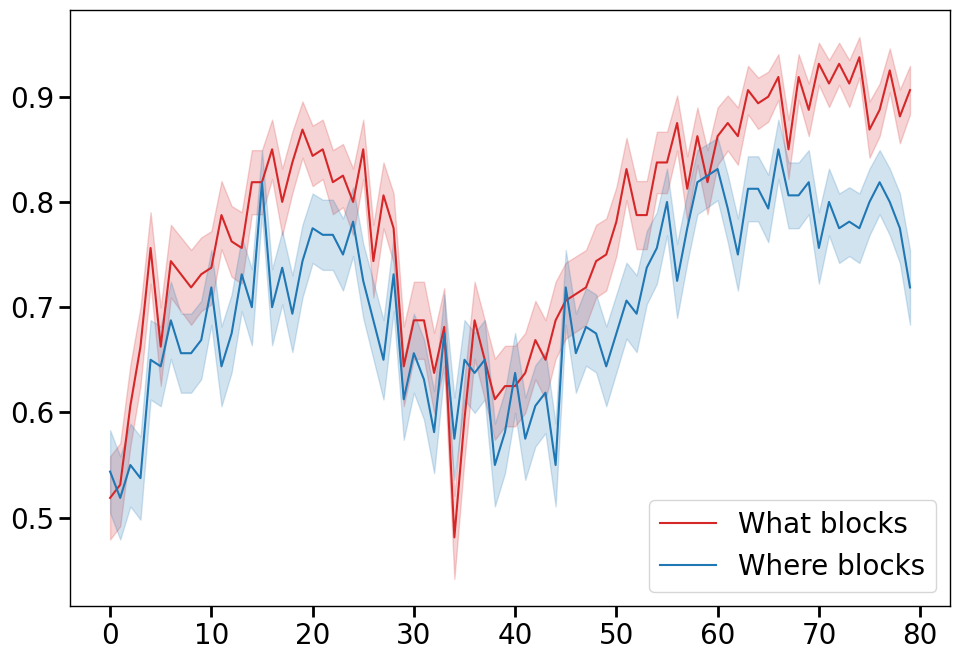

In [11]:
def learning_curves(results_dict):
    # calculate the performance for all models based on the chosen location

    performance = (results_dict['loc_chosen']==np.argmax(results_dict['reward_probs'], axis=-1)).squeeze()

    where_blocks_mask = results_dict['block_type']==0
    what_blocks_mask = results_dict['block_type']==1

    where_blocks_performance = performance[where_blocks_mask]
    what_blocks_performance = performance[what_blocks_mask]

    plt.plot(what_blocks_performance.mean(0), label='What blocks', color='tab:red')
    plt.plot(where_blocks_performance.mean(0), label='Where blocks', color='tab:blue')

    plt.fill_between(np.arange(performance.shape[1]), 
                     what_blocks_performance.mean(0)-what_blocks_performance.std(0)/np.sqrt(what_blocks_performance.shape[0]), 
                     what_blocks_performance.mean(0)+what_blocks_performance.std(0)/np.sqrt(what_blocks_performance.shape[0]), 
                     color='tab:red', alpha=0.2)
    plt.fill_between(np.arange(performance.shape[1]), 
                     where_blocks_performance.mean(0)-where_blocks_performance.std(0)/np.sqrt(where_blocks_performance.shape[0]), 
                     where_blocks_performance.mean(0)+where_blocks_performance.std(0)/np.sqrt(where_blocks_performance.shape[0]), 
                     color='tab:blue', alpha=0.2)
    
    plt.legend()
    plt.tight_layout()
    plt.show()
    return

learning_curves(all_saved_states)

In [12]:
def stay_probs(results_dict):
    # calculate the probability of staying with the same location and stimulus choice given previous trial's reward outcomes
    # results_dict: dict of results from the model
    # return: dict of stay probabilities

    num_blocks, num_trials, _ = results_dict['reward'].shape
    stay_probs = {
        'what_unrewarded_loc': [],
        'what_rewarded_loc': [],
        'where_unrewarded_loc': [],
        'where_rewarded_loc': [],
        'what_unrewarded_img': [],
        'what_rewarded_img': [],
        'where_unrewarded_img': [],
        'where_rewarded_img': [],
    }

    for block_idx in range(num_blocks):
        block_type = results_dict['block_type'][block_idx]
        reward = results_dict['reward'][block_idx]
        img_chosen = results_dict['img_chosen'][block_idx]
        loc_chosen = results_dict['loc_chosen'][block_idx]

        reward_prev = np.isclose(reward[:-1], 1)
        unreward_prev = np.isclose(reward[:-1], 0)

        if block_type == 0:
            stay_probs['where_unrewarded_loc'].append(np.mean(loc_chosen[1:][unreward_prev] == loc_chosen[:-1][unreward_prev]))
            stay_probs['where_unrewarded_img'].append(np.mean(img_chosen[1:][unreward_prev] == img_chosen[:-1][unreward_prev]))
            stay_probs['where_rewarded_loc'].append(np.mean(loc_chosen[1:][reward_prev] == loc_chosen[:-1][reward_prev]))
            stay_probs['where_rewarded_img'].append(np.mean(img_chosen[1:][reward_prev] == img_chosen[:-1][reward_prev]))
        elif block_type == 1:
            stay_probs['what_unrewarded_loc'].append(np.mean(loc_chosen[1:][unreward_prev] == loc_chosen[:-1][unreward_prev]))
            stay_probs['what_unrewarded_img'].append(np.mean(img_chosen[1:][unreward_prev] == img_chosen[:-1][unreward_prev]))
            stay_probs['what_rewarded_loc'].append(np.mean(loc_chosen[1:][reward_prev] == loc_chosen[:-1][reward_prev]))
            stay_probs['what_rewarded_img'].append(np.mean(img_chosen[1:][reward_prev] == img_chosen[:-1][reward_prev]))
        else:
            raise ValueError

    return stay_probs

all_stay_probs = stay_probs(all_saved_states)


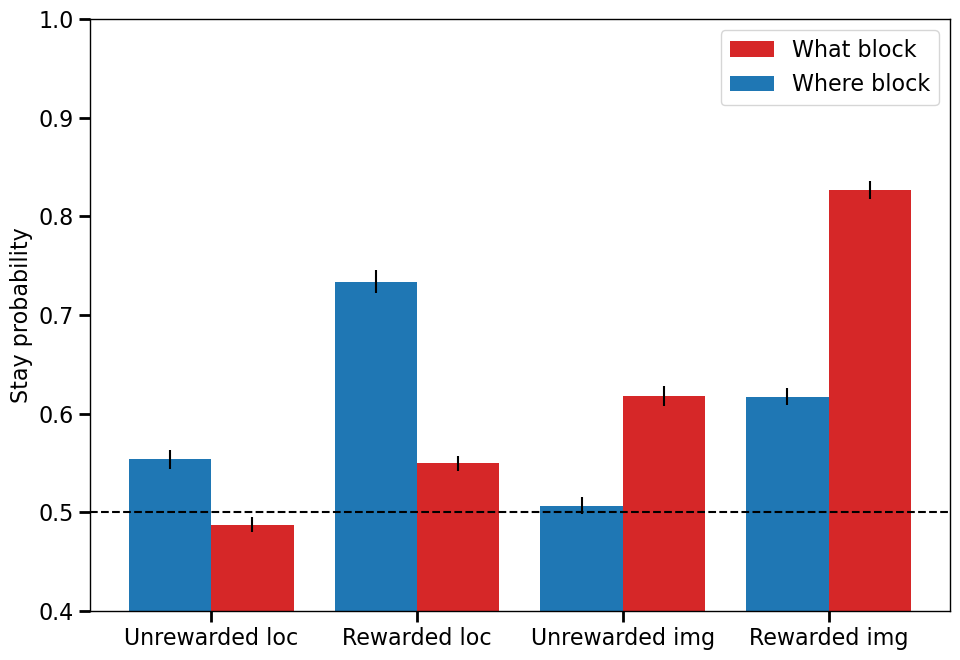

In [16]:
# plot the average stay probabilities in bar plot

stay_probs_what_blocks = [
    [np.mean(all_stay_probs[k]), np.std(all_stay_probs[k])/np.sqrt(len(all_stay_probs[k]))] for k in all_stay_probs.keys() if 'what' in k
]

stay_probs_where_blocks = [
    [np.mean(all_stay_probs[k]), np.std(all_stay_probs[k])/np.sqrt(len(all_stay_probs[k]))] for k in all_stay_probs.keys() if 'where' in k
]

stay_probs_what_blocks = np.array(stay_probs_what_blocks)
stay_probs_where_blocks = np.array(stay_probs_where_blocks)

plt.bar(np.arange(len(stay_probs_what_blocks))+0.2, stay_probs_what_blocks[:,0], color='tab:red', label='What block', width=0.4)
plt.errorbar(np.arange(len(stay_probs_what_blocks))+0.2, stay_probs_what_blocks[:,0], 
             yerr=stay_probs_what_blocks[:,1], color='black', fmt='none')
plt.bar(np.arange(len(stay_probs_where_blocks))-0.2, stay_probs_where_blocks[:,0], color='tab:blue', label='Where block', width=0.4)
plt.errorbar(np.arange(len(stay_probs_where_blocks))-0.2, stay_probs_where_blocks[:,0], 
             yerr=stay_probs_where_blocks[:,1], color='black', fmt='none')
plt.axhline(0.5, ls='--', c='k')

plt.xticks(np.arange(len(stay_probs_what_blocks)), ['Unrewarded loc', 'Rewarded loc', 'Unrewarded img', 'Rewarded img'], fontsize=16)
plt.yticks(fontsize=16)
plt.ylabel('Stay probability', fontsize=16)
plt.legend(fontsize=16)
plt.ylim([0.4, 1.0])

plt.tight_layout()
plt.show()






# Example connectivitiy and learning rates

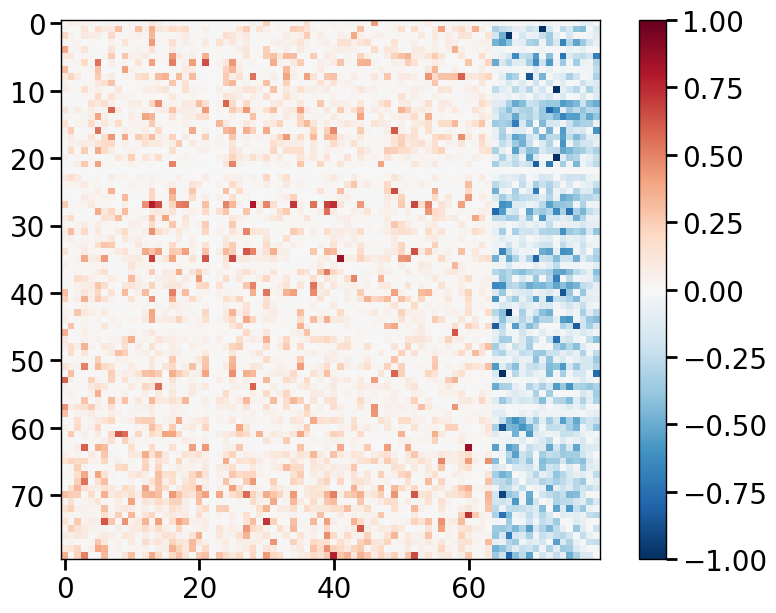

In [3]:
plt.imshow(all_models[np.random.randint(0, len(all_models))].rnn.h2h.effective_weight().detach(), cmap='RdBu_r', norm=mpl.colors.CenteredNorm(vcenter=0))
plt.colorbar()


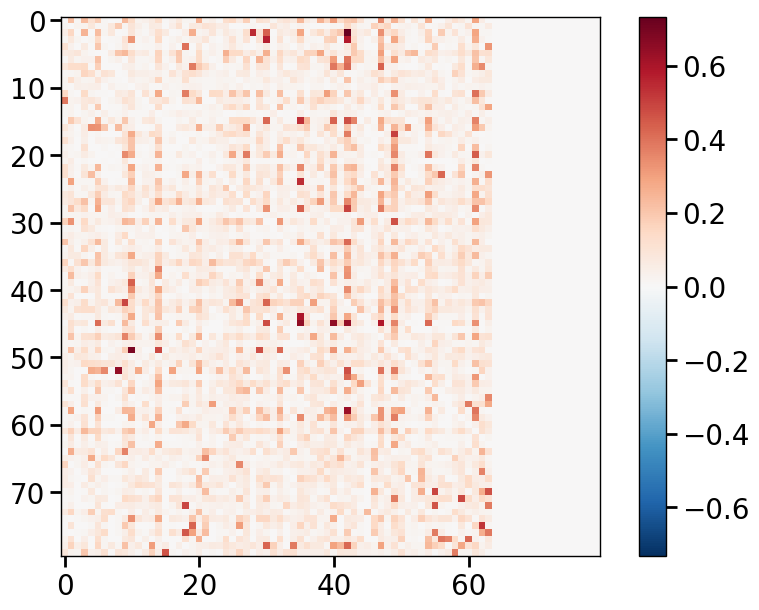

In [4]:
plt.imshow(all_models[np.random.randint(0, len(all_models))].plasticity.effective_lr().detach(),  cmap='RdBu_r', norm=mpl.colors.CenteredNorm(vcenter=0))
plt.colorbar()

# Decomposition of input and output weights subspaces

We want the following dimensions: 
1. Stim dimensions (size 2)
2. Choice readout dimension (size 1)
3. Action feedback dimension (size 1)
4. Reward dimension (size 1)
5. Block type dimension (size 1)

In [19]:
'''decompose the input weights'''

all_model_input_weights_raw = []

for mdl in all_models:
    all_model_input_weights_raw.append(mdl.rnn.x2h['stimulus'].effective_weight().detach())
    
all_model_input_weights_raw = torch.stack(all_model_input_weights_raw, dim=0).reshape(-1, args['hidden_size'], 4) # (num_models, hidden_size, 4)

# for the average stim representation, and the difference between the two locations
all_model_inputs_effective = all_model_input_weights_raw @ np.array([[1,0,-1,0], 
                                                                     [0,1,0,-1]]).T[None] 

'''decompose the output weights'''
all_model_output_weights_raw = []

for mdl in all_models:
    all_model_output_weights_raw.append(mdl.h2o['action'].effective_weight().detach())
    
all_model_output_weights_raw = torch.stack(all_model_output_weights_raw, dim=0).reshape(-1, 3, args['hidden_size']).permute(0,2,1) # (num_models, hidden_size, 4)
all_model_outputs_effective = (all_model_output_weights_raw[:,:,1]-all_model_output_weights_raw[:,:,0])[...,None]

# all_model_outputs_effective = np.stack([
#     (all_model_output_weights_raw[:,:,1]-all_model_output_weights_raw[:,:,0]),
#     (all_model_output_weights_raw[:,:,2]-(all_model_output_weights_raw[:,:,1]+all_model_output_weights_raw[:,:,0])/2)], axis=-1)

'''decompose the action feedback weights'''
all_model_action_feedback_weights = []

for mdl in all_models:
    all_model_action_feedback_weights.append(mdl.rnn.x2h['action'].effective_weight().detach())
    
all_model_action_feedback_weights = torch.stack(all_model_action_feedback_weights, dim=0) # (num_models, hidden_size, 2)

all_model_action_feedback_weights_effective = (all_model_action_feedback_weights[:,:,1]-all_model_action_feedback_weights[:,:,0])[...,None]

'''decompose the reward weights'''
all_model_reward_weights = []
for mdl in all_models:
    all_model_reward_weights.append(mdl.rnn.x2h['reward'].effective_weight().detach())
all_model_reward_weights = torch.stack(all_model_reward_weights, dim=0) # (num_models, hidden_size, 2)
all_model_reward_weights_effective = (all_model_reward_weights[:,:,1]-all_model_reward_weights[:,:,0])[...,None]

'''decompose the fixation weights'''
all_model_fixation_weights = []
for mdl in all_models:
    all_model_fixation_weights.append(mdl.rnn.x2h['fixation'].effective_weight().detach())
all_model_fixation_weights = torch.stack(all_model_fixation_weights, dim=0) # (num_models, hidden_size, 1)
all_model_fixation_weights_effective = all_model_fixation_weights
# orthogonalize the fixation weights from the readout with gram schmidt
# all_model_fixation_weights_effective = all_model_fixation_weights_effective - all_model_fixation_weights_effective@all_model_output_weights_effective[...,1][:,None]/np.linalg.norm()


'''decompose the block type weights'''
all_model_block_type_weights = []
for mdl in all_models:
    all_model_block_type_weights.append(mdl.h2o['block_type'].effective_weight().detach().T)
all_model_block_type_weights = torch.stack(all_model_block_type_weights, dim=0) # (num_models, hidden_size, 2)
all_model_block_type_weights_effective = (all_model_block_type_weights[:,:,1]-all_model_block_type_weights[:,:,0])[...,None]




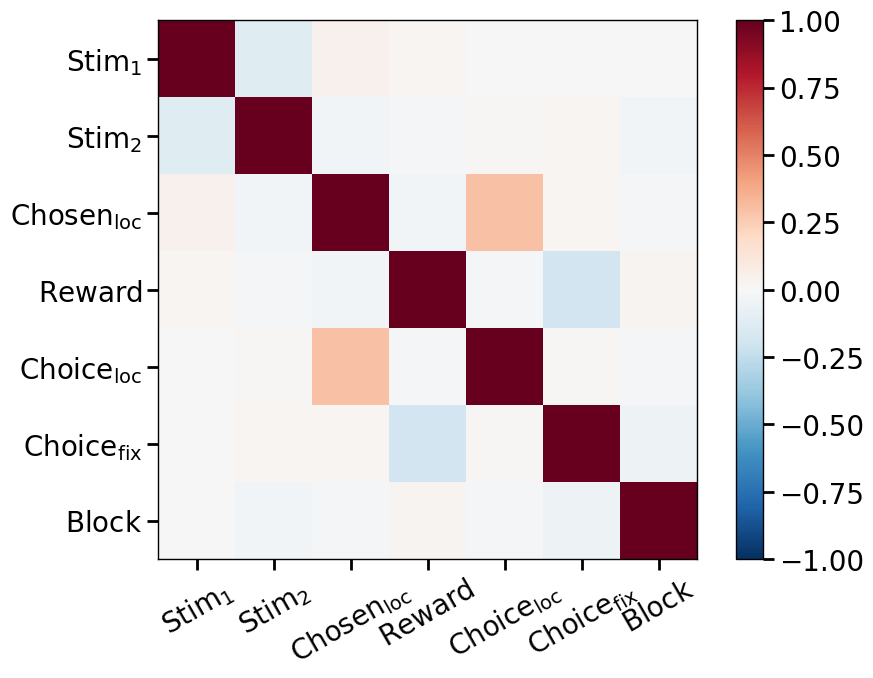

In [20]:
'''calculate the overlap between the bases'''
# ignoring the fixation related bases for now
all_model_bases = np.concatenate([all_model_inputs_effective, 
                                  all_model_action_feedback_weights_effective,
                                  all_model_reward_weights_effective,
                                  all_model_outputs_effective, 
                                  all_model_fixation_weights_effective,
                                  all_model_block_type_weights_effective], axis=-1) # (num_models, hidden_size, 3+1+1+1+1)

# all_model_bases = np.linalg.qr(all_model_bases)[0]

all_model_bases = all_model_bases / (np.linalg.norm(all_model_bases, axis=1, keepdims=True)) 


'''specify names of the axes'''
all_bases_names = [r'$Stim_1$', r'$Stim_2$', r'$Chosen_{loc}$', r'$Reward$', r'$Choice_{loc}$', r'$Choice_{fix}$', r'$Block$']

plt.imshow(np.mean([all_model_bases[i].T@all_model_bases[i] for i in range(8)], 0), 
           cmap='RdBu_r', vmin=-1, vmax=1)
plt.xticks(range(len(all_bases_names)), all_bases_names, rotation=30)
plt.yticks(range(len(all_bases_names)), all_bases_names)
plt.colorbar()

# Clustering of units into distinct populations

In [21]:
all_model_weights = np.concatenate([all_model_input_weights_raw, 
                                    all_model_output_weights_raw, 
                                    all_model_action_feedback_weights,
                                    all_model_reward_weights,
                                    all_model_fixation_weights,
                                    all_model_block_type_weights], axis=-1)

all_model_weight_names = [r'$Stim_{left, 1}$', r'$Stim_{left, 2}$', 
                          r'$Stim_{right, 1}$', r'$Stim_{right, 2}$', 
                          r'$Choice_{left}$', r'$Choice_{right}$', r'$Choice_{fixation}$',
                          r'$Loc_{chosen, left}$', r'$Loc_{chosen, right}$', 
                          r'$Reward_{-}$', r'$Reward_{+}$',  r'$Fixation$',
                          r'$Block_{where}$', r'$Block_{what}$']

# all_model_weights /= np.linalg.norm(all_model_weights, axis=1, keepdims=True)


n_clusters=2, silhouette_score=0.399
n_clusters=3, silhouette_score=0.355
n_clusters=4, silhouette_score=0.382
n_clusters=5, silhouette_score=0.417
n_clusters=6, silhouette_score=0.462
n_clusters=7, silhouette_score=0.436
n_clusters=8, silhouette_score=0.403
n_clusters=9, silhouette_score=0.404
n_clusters=10, silhouette_score=0.414
n_clusters=11, silhouette_score=0.376
n_clusters=12, silhouette_score=0.363
n_clusters=13, silhouette_score=0.370
n_clusters=14, silhouette_score=0.332


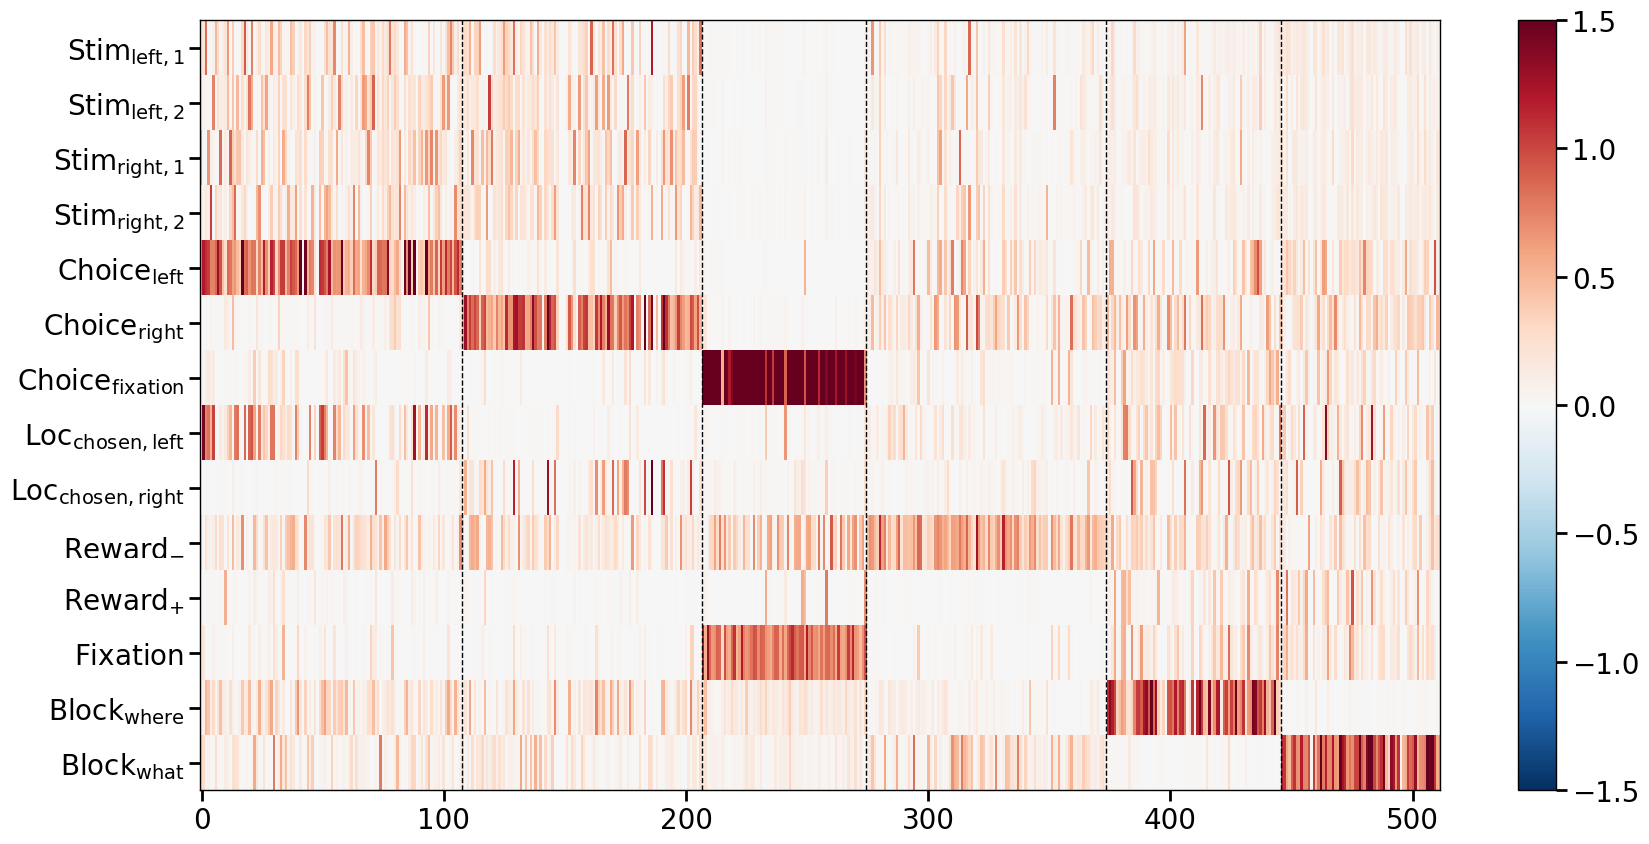

n_clusters=2, silhouette_score=0.527
n_clusters=3, silhouette_score=0.555
n_clusters=4, silhouette_score=0.568
n_clusters=5, silhouette_score=0.574
n_clusters=6, silhouette_score=0.525
n_clusters=7, silhouette_score=0.525
n_clusters=8, silhouette_score=0.431
n_clusters=9, silhouette_score=0.332
n_clusters=10, silhouette_score=0.296
n_clusters=11, silhouette_score=0.208
n_clusters=12, silhouette_score=0.094
n_clusters=13, silhouette_score=0.063
n_clusters=14, silhouette_score=0.080


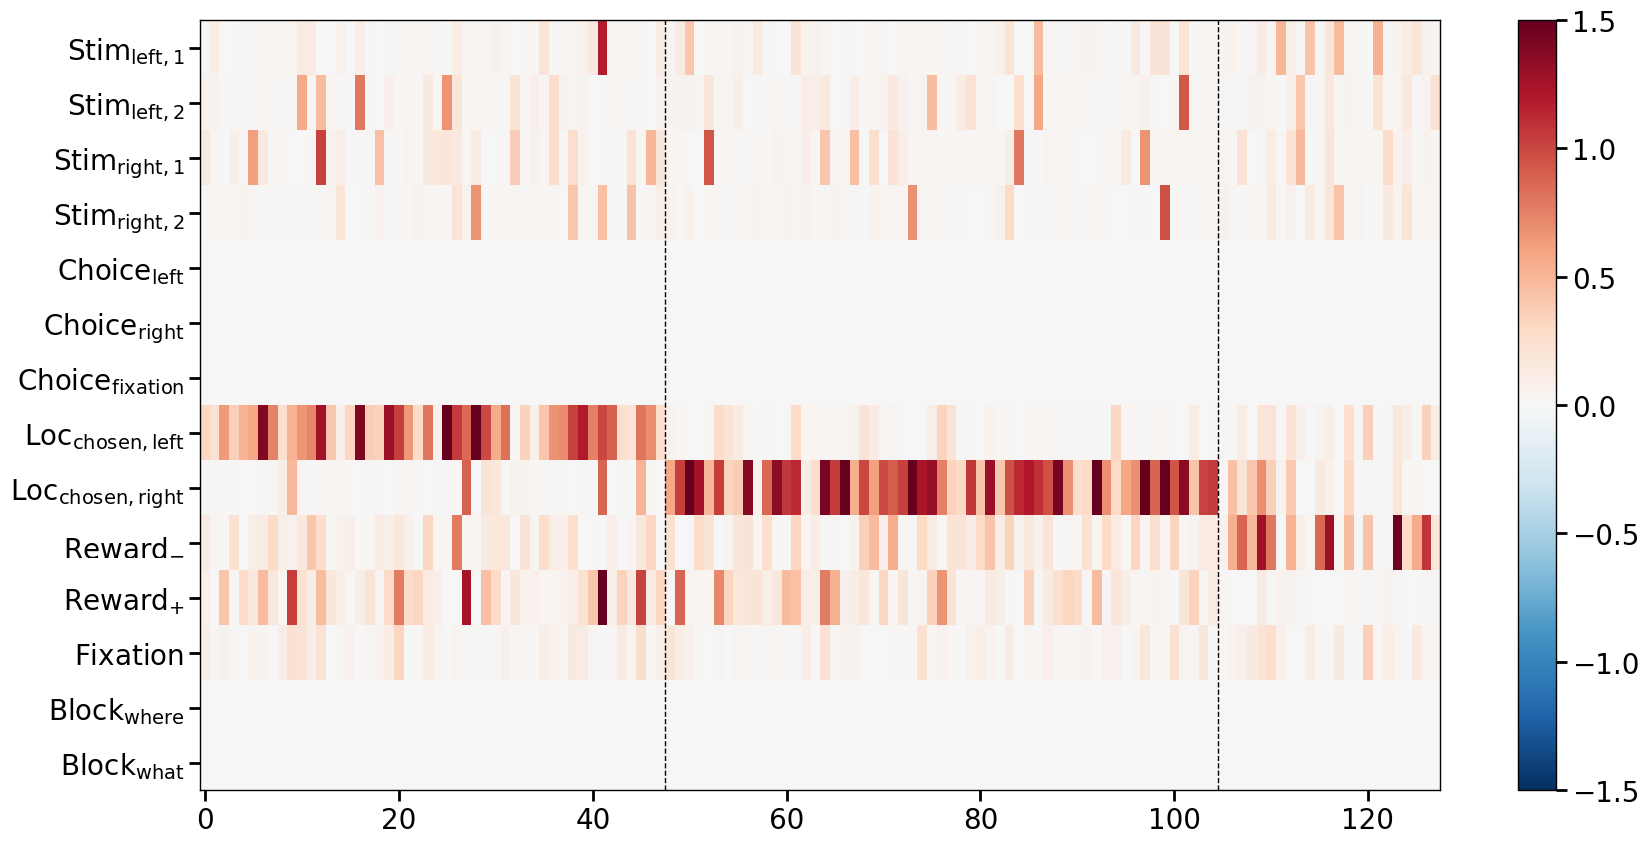

In [22]:
from sklearn.cluster import SpectralClustering, KMeans
from sklearn.metrics import silhouette_score

all_model_clusters = []

def cluster_units(all_model_weights, ideal_n_clusters):
    # all_model_weights: shape (num_models, hidden_size, num_features)
    # Concatenate all hidden units from all models: (num_models * hidden_size, num_features)
    all_units = all_model_weights.reshape(-1, all_model_weights.shape[-1])

    silhouette_scores = []
    cluster_range = range(2, 15)  # Try 2 to 10 clusters

    for n_clusters in cluster_range:
        clustering = SpectralClustering(n_clusters=n_clusters, affinity='cosine', assign_labels='kmeans', gamma=1/all_units.shape[-1], n_init=20)
        labels = clustering.fit_predict(all_units)
        score = silhouette_score(all_units, labels, metric='cosine')
        silhouette_scores.append(score)
        print(f"n_clusters={n_clusters}, silhouette_score={score:.3f}")

    clustering = SpectralClustering(n_clusters=ideal_n_clusters, affinity='cosine', assign_labels='kmeans', gamma=1/all_units.shape[-1], n_init=20)
    labels = clustering.fit_predict(all_units)

    # Calculate centroids
    centroids = np.stack([all_units[labels == k].mean(0) for k in range(ideal_n_clusters)], axis=0)

    label_sort_idx = np.argsort(np.argmax(centroids, axis=1))

    sorted_labels = np.zeros_like(labels)
    for i, k in enumerate(label_sort_idx):
        sorted_labels[labels == k] = i

    sorted_units = np.concatenate([all_units[labels == k] for k in label_sort_idx], axis=0)

    fig, ax = plt.subplots(figsize=(20, 10))
    im = ax.imshow(sorted_units.T, aspect='auto', cmap='RdBu_r', norm=mpl.colors.CenteredNorm(vcenter=0, halfrange=1.5))

    ax.set_yticks(range(len(all_model_weight_names)), all_model_weight_names, rotation=0)

    label_counts = np.bincount(labels)[label_sort_idx]
    for bound in np.cumsum(label_counts)[:-1]:
        ax.axvline(bound-0.5, color='black', linestyle='--', lw=1)

    fig.colorbar(im)
    plt.show()

    return sorted_labels.reshape(all_model_weights.shape[:2])

ideal_exc_clusters = 6
all_model_exc_clusters = cluster_units(np.stack([weight[:E_SIZE] for weight in all_model_weights], axis=0), ideal_exc_clusters)

ideal_inh_clusters = 3
all_model_inh_clusters = cluster_units(np.stack([weight[E_SIZE:] for weight in all_model_weights], axis=0), ideal_inh_clusters)



In [23]:
e_cluster_names = [r'$E_{left}$', r'$E_{right}$', r'$E_{fixation}$', r'$E_{reward-}$', r'$E_{where}$', r'$E_{what}$']
i_cluster_names = [r'$I_{left}$', r'$I_{right}$', r'$I_{reward-}$']

# Transformation of bases by recurrent weights

In [24]:
'''get all model's recurrent weights'''

all_model_recurrent_weights = []
for mdl in all_models:
    all_model_recurrent_weights.append(mdl.rnn.h2h.effective_weight().detach())
all_model_recurrent_weights = torch.stack(all_model_recurrent_weights, dim=0)  # (num_models, hidden_size, hidden_size)


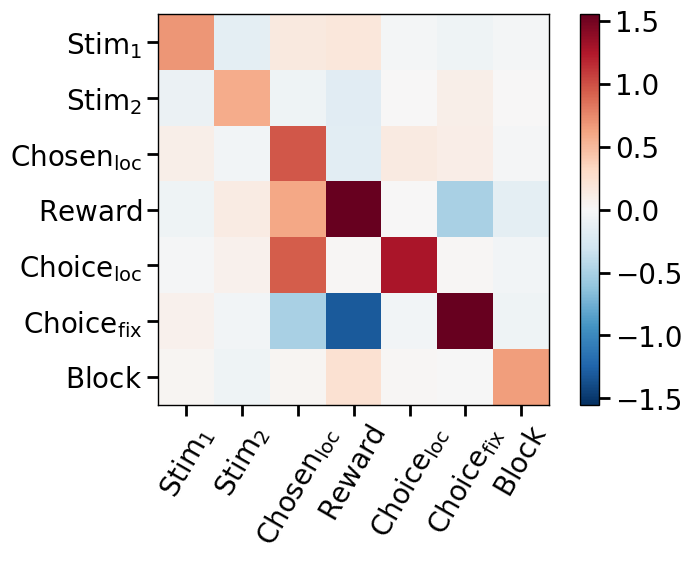

In [216]:
# Visualize how the recurrent weight transforms the input bases by performing a matrix change of variable
# For each model, transform the input bases by its recurrent weight, then average the resulting correlation matrices

num_models = all_model_recurrent_weights.shape[0]
num_bases = all_model_bases.shape[-1]

corrs = []
for i in range(num_models):
    W_rec = all_model_recurrent_weights[i].numpy()  # (hidden_size, hidden_size)
    input_bases = all_model_bases[i]  # (hidden_size, num_bases)
    transformed_bases = W_rec @ input_bases  # (hidden_size, num_bases)
#     transformed_bases = transformed_bases / np.linalg.norm(transformed_bases, axis=0, keepdims=True)
    corr = input_bases.T @ transformed_bases # (num_bases, num_bases)
    corrs.append(corr)

mean_corr = np.mean(corrs, axis=0)
plt.figure(figsize=(8,6))
plt.imshow(mean_corr, cmap='RdBu_r', norm=mpl.colors.CenteredNorm(vcenter=0))
plt.colorbar()
plt.xticks(range(num_bases), all_bases_names, rotation=60)
plt.yticks(range(num_bases), all_bases_names)

plt.tight_layout()

plt.show()



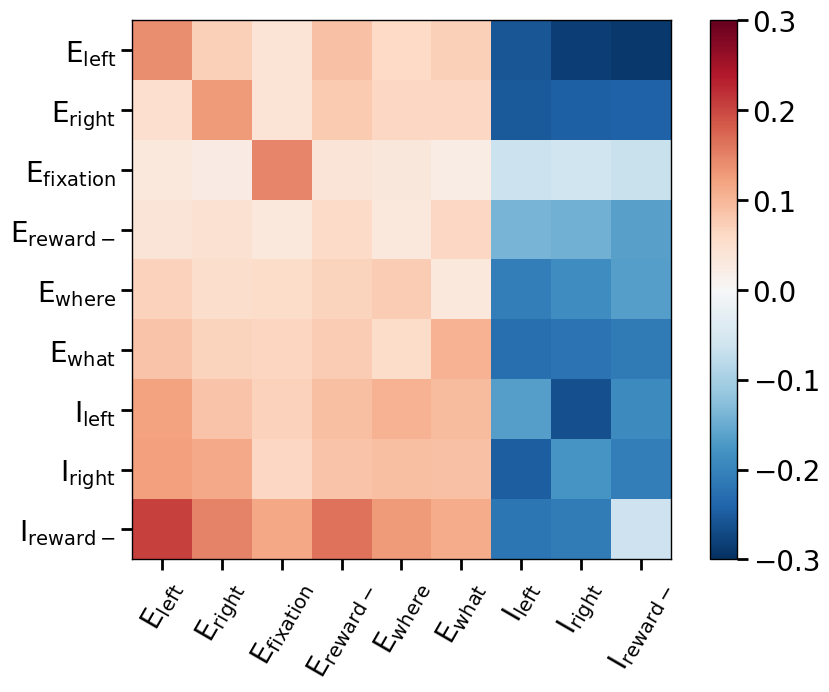

In [26]:
cluster_connections = []

for mdl_idx in range(all_model_weights.shape[0]):
    curr_mdl_cluster_connections = np.zeros((ideal_exc_clusters+ideal_inh_clusters, ideal_exc_clusters+ideal_inh_clusters))
    curr_mdl_exc_clusters = all_model_exc_clusters[mdl_idx]
    curr_mdl_inh_clusters = all_model_inh_clusters[mdl_idx]
    for i in range(ideal_exc_clusters):
        for j in range(ideal_exc_clusters):
            curr_mdl_cluster_connections[i, j] = \
                all_model_recurrent_weights[mdl_idx,:E_SIZE,:E_SIZE][curr_mdl_exc_clusters==i][:, curr_mdl_exc_clusters==j].mean()
    for i in range(ideal_exc_clusters):
        for j in range(ideal_inh_clusters):
            curr_mdl_cluster_connections[i, j+ideal_exc_clusters] = \
                all_model_recurrent_weights[mdl_idx,:E_SIZE,E_SIZE:][curr_mdl_exc_clusters==i][:, curr_mdl_inh_clusters==j].mean()
    for i in range(ideal_inh_clusters):
        for j in range(ideal_exc_clusters):
            curr_mdl_cluster_connections[i+ideal_exc_clusters, j] = \
                all_model_recurrent_weights[mdl_idx,E_SIZE:,:E_SIZE][curr_mdl_inh_clusters==i][:, curr_mdl_exc_clusters==j].mean()
    for i in range(ideal_inh_clusters):
        for j in range(ideal_inh_clusters):
            curr_mdl_cluster_connections[i+ideal_exc_clusters, j+ideal_exc_clusters] = \
                all_model_recurrent_weights[mdl_idx,E_SIZE:,E_SIZE:][curr_mdl_inh_clusters==i][:, curr_mdl_inh_clusters==j].mean()
    cluster_connections.append(curr_mdl_cluster_connections)

cluster_connections = np.array(cluster_connections)

plt.imshow(cluster_connections.mean(0), cmap='RdBu_r', norm=mpl.colors.CenteredNorm(vcenter=0, halfrange=0.3))
plt.xticks(range(ideal_exc_clusters+ideal_inh_clusters), e_cluster_names+i_cluster_names, rotation=60)
plt.yticks(range(ideal_exc_clusters+ideal_inh_clusters), e_cluster_names+i_cluster_names)
plt.colorbar()

# Encoding and recall of the stim and action subspaces by plasticity

In [27]:
all_model_learning_rates = []
for mdl in all_models:
    all_model_learning_rates.append(mdl.plasticity.effective_lr().detach().numpy())
all_model_learning_rates = np.stack(all_model_learning_rates, axis=0)  # (num_models, hidden_size, hidden_size)

/scratch/f005d7d/ipykernel_2481961/1026272459.py:15: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  all_model_assoc_learning_rates[mdl_idx, i, j] = recall


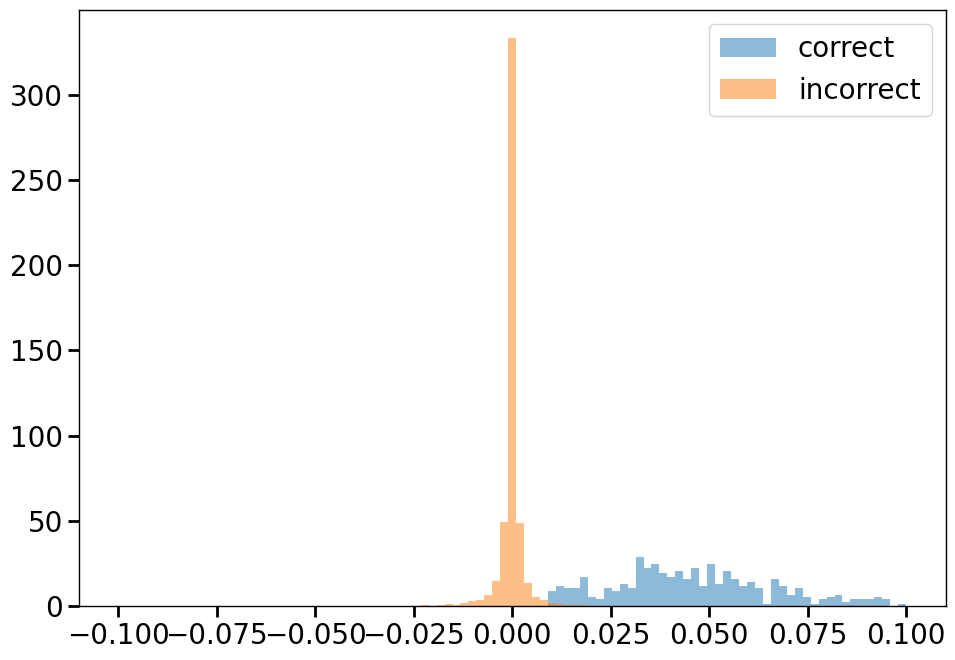

In [28]:
from itertools import product

all_model_recall_correct = []
all_model_recall_incorrect = []

all_model_assoc_learning_rates = np.nan*np.empty((all_model_bases.shape[0], all_model_bases.shape[-1], all_model_bases.shape[-1]))

for mdl_idx in range(all_model_bases.shape[0]):
    for (i, j, k, l) in product(range(all_model_bases.shape[-1]), range(all_model_bases.shape[-1]), range(all_model_bases.shape[-1]), range(all_model_bases.shape[-1])):
        mem = all_model_bases[mdl_idx,:,i][:, None]*all_model_learning_rates[mdl_idx]*all_model_bases[mdl_idx,:,j][None] # (hidden_size, 1) * (hidden_size, hidden_size) * (1, hidden_size) = (hidden_size, hidden_size)
        recall = all_model_bases[mdl_idx,:,k][None]@mem@all_model_bases[mdl_idx,:,l][:,None] # (1, hidden_size) @ (hidden_size, hidden_size) @ (hidden_size, 1) = (1, 1)

        if i==k and j==l:
            all_model_recall_correct.append(recall)
            all_model_assoc_learning_rates[mdl_idx, i, j] = recall
        else:
            all_model_recall_incorrect.append(recall)

all_model_recall_correct = np.array(all_model_recall_correct)   
all_model_recall_incorrect = np.array(all_model_recall_incorrect)

plt.hist(all_model_recall_correct.flatten(), bins=np.linspace(-0.1, 0.1, 100), alpha=0.5, label='correct', density=True)
plt.hist(all_model_recall_incorrect.flatten(), bins=np.linspace(-0.1, 0.1, 100), alpha=0.5, label='incorrect', density=True)
plt.legend()
plt.tight_layout()
plt.show()

    

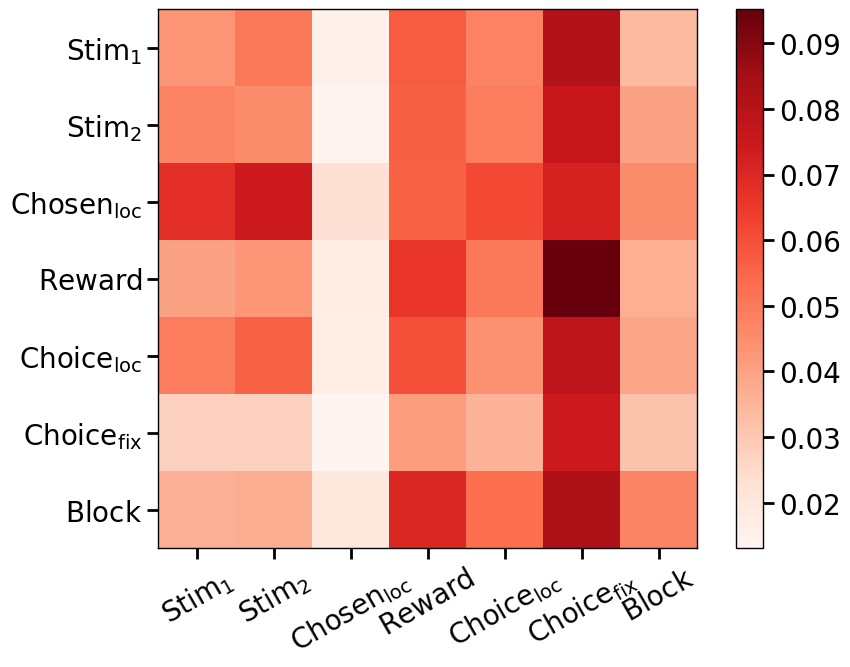

In [29]:
plt.imshow(all_model_assoc_learning_rates.mean(0), cmap='Reds')
plt.xticks(range(all_model_bases.shape[-1]), all_bases_names, rotation=30)
plt.yticks(range(all_model_bases.shape[-1]), all_bases_names)
plt.colorbar()

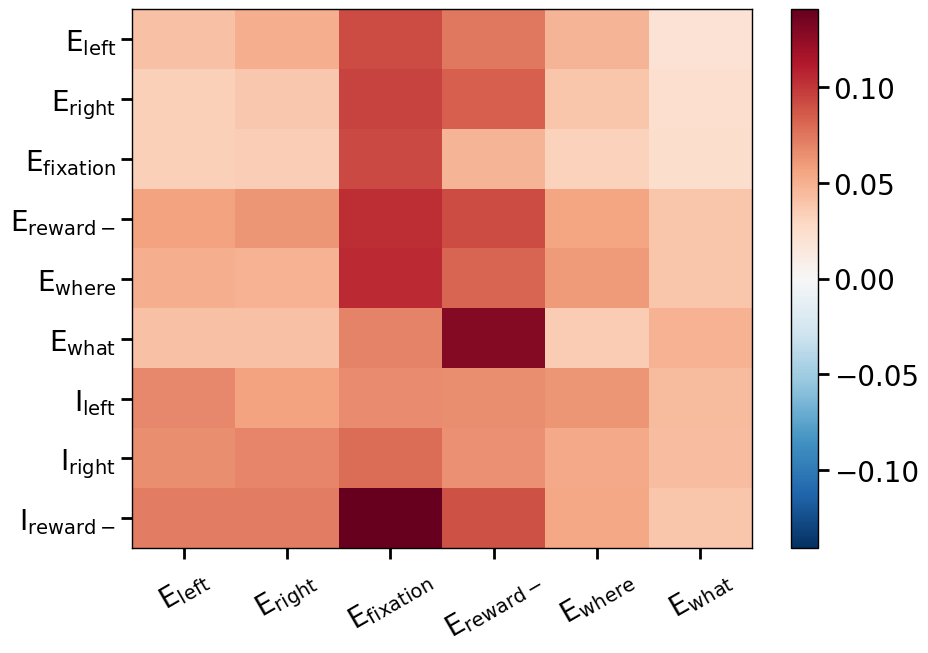

In [30]:
cluster_connections = []

for mdl_idx in range(all_model_learning_rates.shape[0]):
    curr_mdl_cluster_connections = np.zeros((ideal_exc_clusters+ideal_inh_clusters, ideal_exc_clusters))
    curr_mdl_exc_clusters = all_model_exc_clusters[mdl_idx]
    curr_mdl_inh_clusters = all_model_inh_clusters[mdl_idx]
    for i in range(ideal_exc_clusters):
        for j in range(ideal_exc_clusters):
            curr_mdl_cluster_connections[i, j] = \
                all_model_learning_rates[mdl_idx,:E_SIZE,:E_SIZE][curr_mdl_exc_clusters==i][:, curr_mdl_exc_clusters==j].mean()
    for i in range(ideal_inh_clusters):
        for j in range(ideal_exc_clusters):
            curr_mdl_cluster_connections[i+ideal_exc_clusters, j] = \
                all_model_learning_rates[mdl_idx,E_SIZE:,:E_SIZE][curr_mdl_inh_clusters==i][:, curr_mdl_exc_clusters==j].mean()

    cluster_connections.append(curr_mdl_cluster_connections)

cluster_connections = np.array(cluster_connections)

plt.imshow(cluster_connections.mean(0), cmap='RdBu_r', aspect='auto', norm=mpl.colors.CenteredNorm(vcenter=0))
plt.xticks(range(ideal_exc_clusters), e_cluster_names, rotation=30)
plt.yticks(range(ideal_exc_clusters+ideal_inh_clusters), e_cluster_names+i_cluster_names)
plt.colorbar()

# Analyses of simulation results

In [107]:
neuron_state_proj = np.empty((*all_saved_states['neuron_states'].shape[:3], all_model_bases.shape[-1]))

for mdl_idx, mdl_bases in enumerate(all_model_bases):
    print(mdl_idx)
    mdl_mask = all_saved_states['model_index']==mdl_idx
    mdl_neuron_states = np.tanh(np.maximum(all_saved_states['neuron_states'][mdl_mask].squeeze(), 0))
    neuron_state_proj[mdl_mask] = (mdl_neuron_states[...,None]*mdl_bases[None,None,None]).sum(-2)
    
neuron_state_proj = np.stack(neuron_state_proj)

0
1
2
3
4
5
6
7


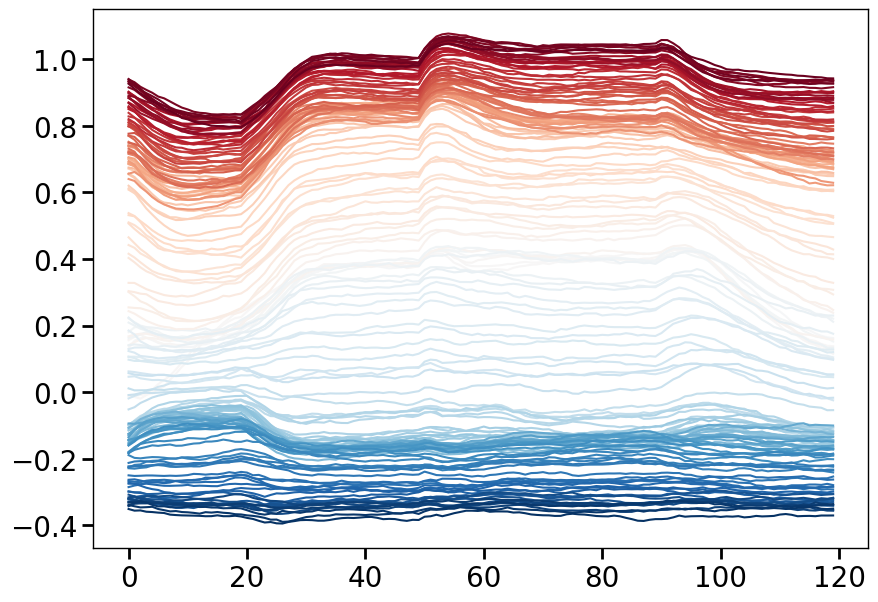

In [203]:
def plot_block_type_projection(neuron_state_proj, all_saved_states):
    where_blk_mask = (all_saved_states['block_type']==0)
    
    num_trials = neuron_state_proj.shape[1]
    
    cmap = mpl.colormaps['RdBu_r']
    colors = cmap(np.linspace(0, 1, 2*num_trials+1))
    
    for trial_idx in range(neuron_state_proj.shape[1]):
        plt.plot((neuron_state_proj[where_blk_mask,trial_idx,:,-1]).mean((0)).T,
                    c=colors[num_trials-trial_idx]);
        plt.plot((neuron_state_proj[~where_blk_mask,trial_idx,:,-1]).mean((0)).T,
                    c=colors[num_trials+trial_idx]);
        
    fig.tight_layout()
    
    plt.show()
    
plot_block_type_projection(neuron_state_proj, all_saved_states)
    

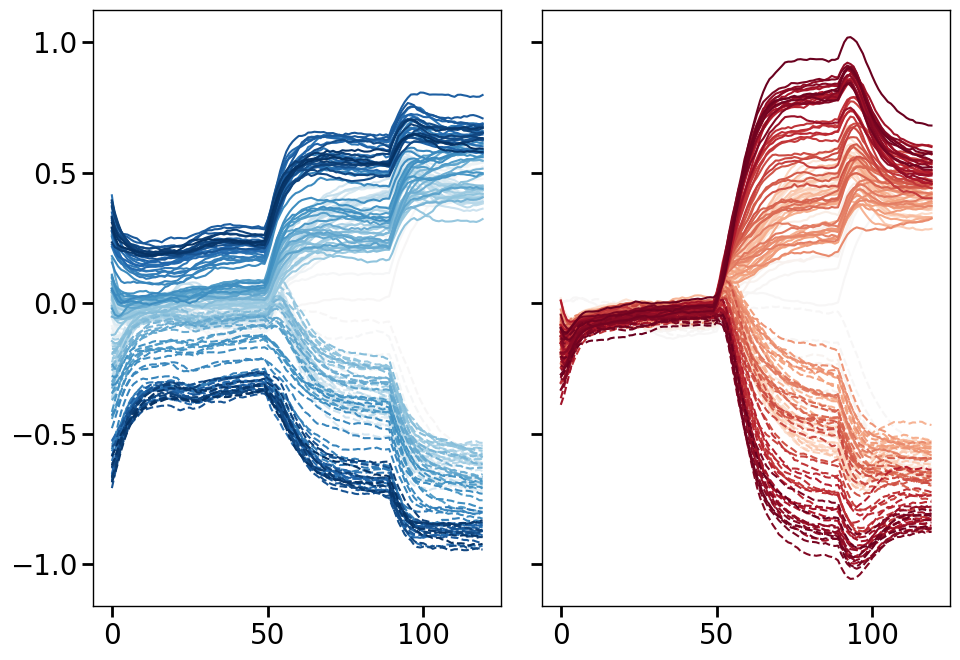

In [213]:
def plot_projection_by_blk_type(neuron_state_proj, all_saved_states, dim_to_plot, var_key_name):
    where_blk_mask = (all_saved_states['block_type']==0)
    
    num_trials = neuron_state_proj.shape[1]
    
    fig, axes = plt.subplots(1,2, sharex=True, sharey=True)
    
    var_mask = (all_saved_states[var_key_name]==0).squeeze()
    
    cmap = mpl.colormaps['RdBu_r']
    colors = cmap(np.linspace(0, 1, 2*num_trials+1))
    
    for trial_idx in range(neuron_state_proj.shape[1]):
    
        axes[0].plot((neuron_state_proj[where_blk_mask&var_mask[:,trial_idx],trial_idx,:,dim_to_plot]).mean((0)).T,
                    c=colors[num_trials-trial_idx], ls='--');
        axes[0].plot((neuron_state_proj[where_blk_mask&~var_mask[:,trial_idx],trial_idx,:,dim_to_plot]).mean((0)).T,
                    c=colors[num_trials-trial_idx]);
    

        axes[1].plot((neuron_state_proj[~where_blk_mask&var_mask[:,trial_idx],trial_idx,:,dim_to_plot]).mean((0)).T,
                    c=colors[num_trials+trial_idx], ls='--');
        axes[1].plot((neuron_state_proj[~where_blk_mask&~var_mask[:,trial_idx],trial_idx,:,dim_to_plot]).mean((0)).T,
                    c=colors[num_trials+trial_idx]);
    
    fig.tight_layout()
    
    plt.show()
    
plot_projection_by_blk_type(neuron_state_proj, all_saved_states, 4, 'loc_chosen')
    
    

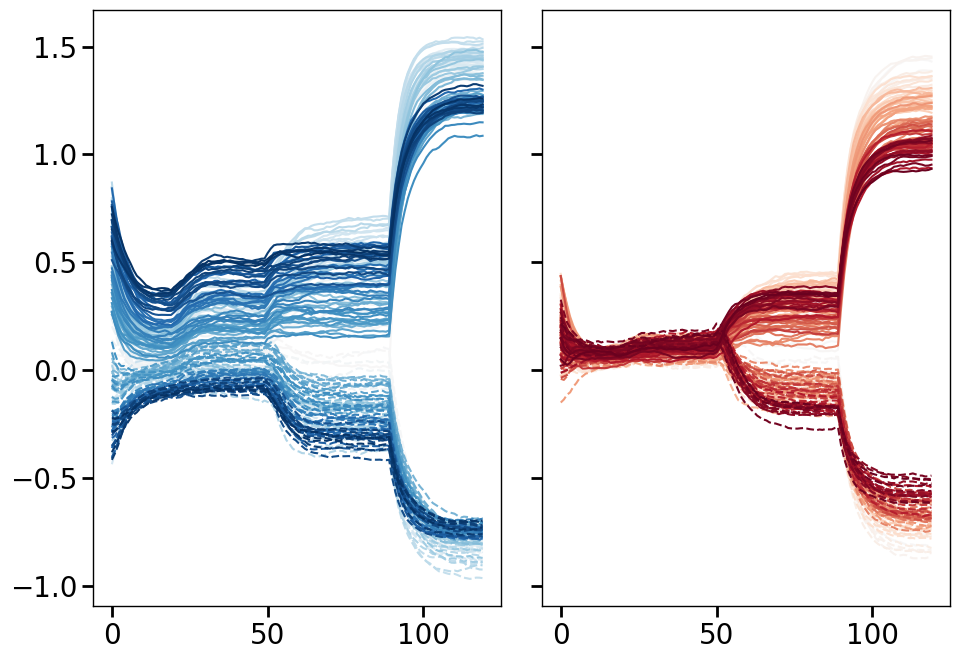

In [214]:
plot_projection_by_blk_type(neuron_state_proj, all_saved_states, 2, 'loc_chosen')

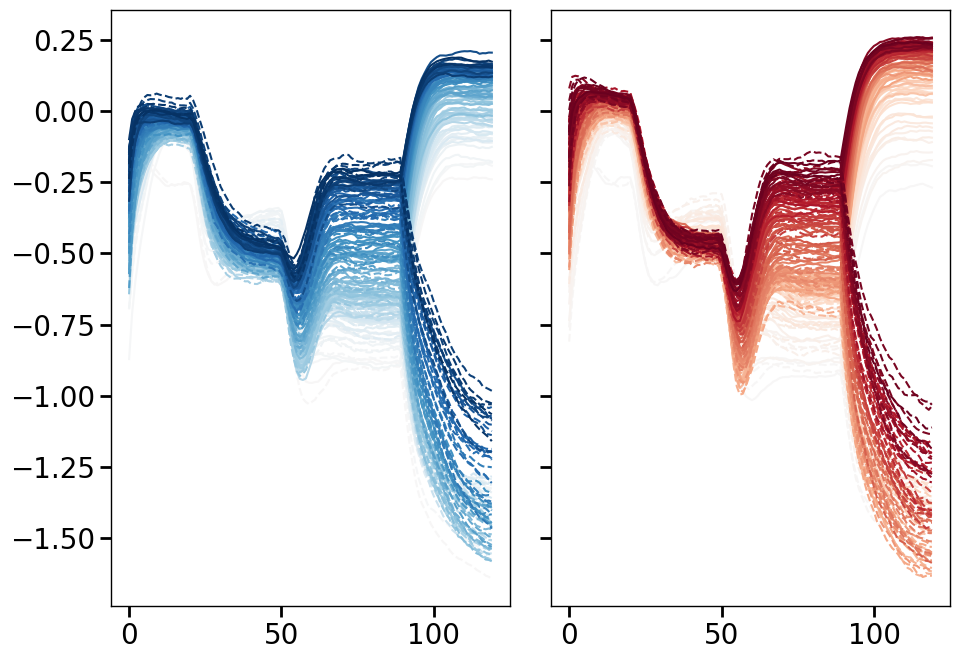

In [215]:
plot_projection_by_blk_type(neuron_state_proj, all_saved_states, 3, 'reward')

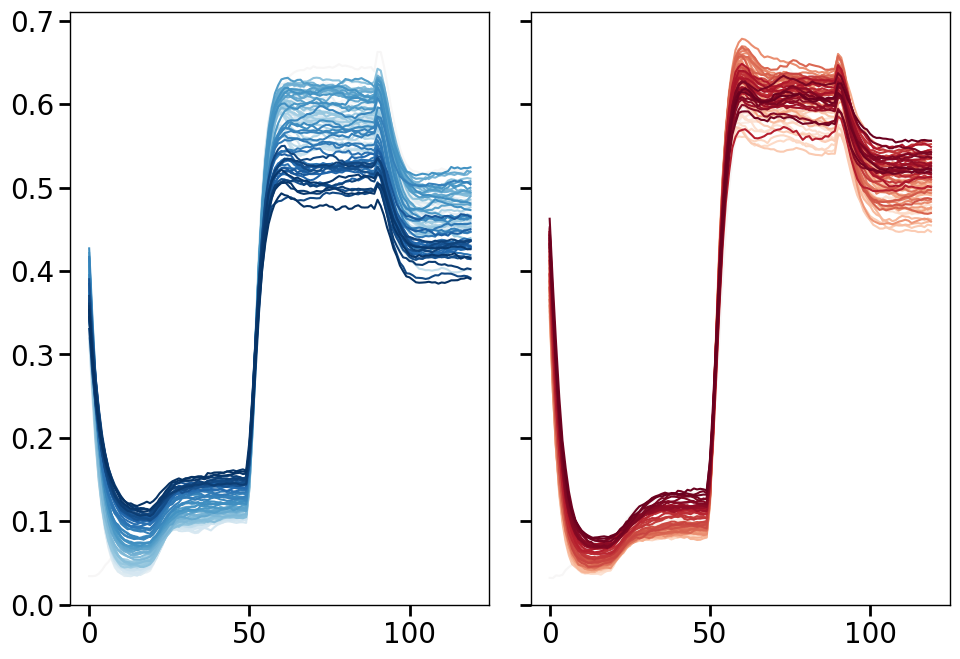

In [212]:
def plot_abs_proj_by_blk_type(neuron_state_proj, all_saved_states, dims_to_plot):
    where_blk_mask = (all_saved_states['block_type']==0)
    
    num_trials = neuron_state_proj.shape[1]
    
    fig, axes = plt.subplots(1,2, sharex=True, sharey=True)
        
    cmap = mpl.colormaps['RdBu_r']
    colors = cmap(np.linspace(0, 1, 2*num_trials+1))
    
    
    for trial_idx in range(neuron_state_proj.shape[1]):
    
        axes[0].plot(np.abs(neuron_state_proj[where_blk_mask,trial_idx][...,dims_to_plot]).mean((0,-1)).T,
                    c=colors[num_trials-trial_idx]);
        axes[1].plot(np.abs(neuron_state_proj[~where_blk_mask,trial_idx][...,dims_to_plot]).mean((0,-1)).T,
                    c=colors[num_trials+trial_idx]);
    
    fig.tight_layout()
    
    plt.show()
    
plot_abs_proj_by_blk_type(neuron_state_proj, all_saved_states, [0,1])
    
    